In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from operator import itemgetter
import seaborn
from sklearn import cross_validation
from sklearn import preprocessing
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

In [2]:
data = pd.read_csv('baseline.csv')
data.head()

,Y,district,date,sentmon,sentyr,bookpost,trial,monsex,newcit,neweduc,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,neweduc_6,neweduc_5,neweduc_3,neweduc_1
0,1,53,11774,3,1992,0,0,0,0,5,...,0,0,0,0,0,0,0,1,0,0
1,1,53,11774,3,1992,0,0,0,0,3,...,0,0,0,0,0,0,0,0,1,0
2,-1,70,11760,3,1992,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
3,1,70,11760,3,1992,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
4,-1,70,11760,3,1992,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


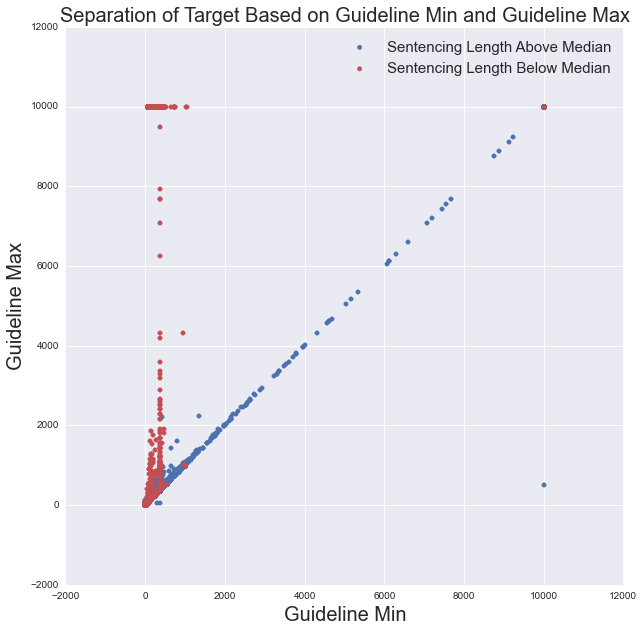

In [3]:
#Visualize relationship between Guideline Min, Guideline Max, and baseline target variable {-1, 1}.
#Through this we can see that our target is largely separable based on Guideline Min and Max.

plt.figure(facecolor = 'w', figsize = (10, 10))
plt.scatter(data[data['Y']==1]['glmin'],data[data['Y']==1]['glmax'],color = 'b', label = 'Sentencing Length Above Median')
plt.scatter(data[data['Y']==-1]['glmin'],data[data['Y']==-1]['glmax'],color = 'r',label = 'Sentencing Length Below Median')
plt.xlabel('Guideline Min',fontsize = 20)
plt.ylabel('Guideline Max',fontsize = 20)
plt.legend(fontsize = 15)
plt.title('Separation of Target Based on Guideline Min and Guideline Max',fontsize = 20)

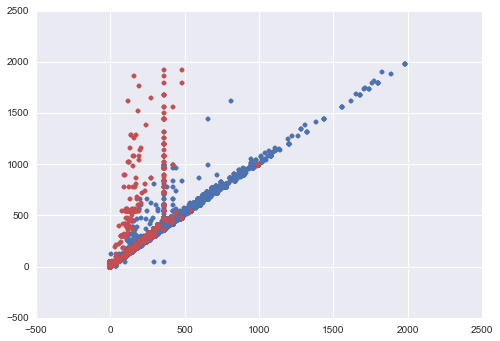

In [4]:
#Zoom in on interval [0, 2000]

test = data[data['glmin'] < 2000]
test = test[test['glmax'] < 2000]
plt.scatter(test[test['Y']==1]['glmin'],test[test['Y']==1]['glmax'],color = 'b')
plt.scatter(test[test['Y']==-1]['glmin'],test[test['Y']==-1]['glmax'],color = 'r')
plt.show()

In [3]:
#Create indexes for split
split = cross_validation.ShuffleSplit(data.shape[0], n_iter=1, train_size = 0.6, test_size=.2, random_state = 1)

for train, test in split:
    train_index = train
    test_index = test
    validation_index = np.arange(data.shape[0])
    validation_index = set(validation_index) - set(train_index) - set(test_index)

In [4]:
#Divide dataframe into train, test, and validation
data_train = data.ix[train_index,:]
data_test = data.ix[test_index,:]
data_validation = data.ix[validation_index,:]

In [5]:
#Normalizie the data
min_max_scaler = preprocessing.MinMaxScaler()
data_train.ix[:,1:] = min_max_scaler.fit_transform(data_train.ix[:,1:])

#The scaler instance is used on test and validation data to transform it the same way it did on the training set
data_test.ix[:,1:] = min_max_scaler.transform(data_test.ix[:,1:]) 
data_validation.ix[:,1:] = min_max_scaler.transform(data_validation.ix[:,1:]) 

In [6]:
#Fit logistic regression model
logreg = linear_model.LogisticRegression(C = 1e30)
logreg.fit(data_train.ix[:,1:], data_train.ix[:,0])
log_predict = logreg.decision_function(data_test.ix[:,1:])

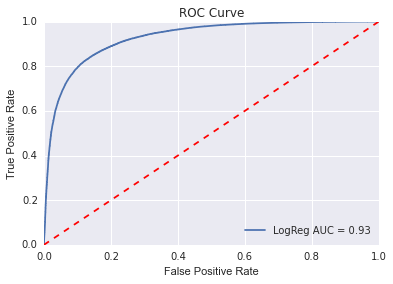

In [104]:
#Plot ROC curve
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(data_test.ix[:,0], log_predict)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('ROC Curve')
plt.plot(false_positive_rate, true_positive_rate, label='LogReg AUC = %0.2f'% roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [8]:
#Extract most important features
coeffs = logreg.coef_
lst = np.array(coeffs).tolist()
lst = lst[0]
sorted_coeffs = sorted(lst, key = abs, reverse = True)
top_20 = sorted_coeffs[:20]
X_train = data_train.ix[:,1:]

In [9]:
#Create dictionaries of these features
neg_features = OrderedDict()
pos_features = OrderedDict()
for i in range(len(lst)):
    for j in range(len(top_20)):
        if lst[i] == top_20[j]:
            if np.sign(lst[i]) < 0:
                neg_features[X_train.columns[i]] = lst[i]
                pos_features[X_train.columns[i]] = 0
            else:
                pos_features[X_train.columns[i]] = lst[i]
                neg_features[X_train.columns[i]] = 0

In [10]:
#Sort these dictionaries in the same way, so they match up in the plot
features = []
for x in top_20:
    if x in pos_features.values():
        for key in pos_features.keys():
            if pos_features[key] == x:
                features.append(key)
    else:
        for key in neg_features.keys():
            if neg_features[key] == x:
                features.append(key)

In [11]:
neg = OrderedDict((k, neg_features[k]) for k in features)
pos = OrderedDict((k, pos_features[k]) for k in features)

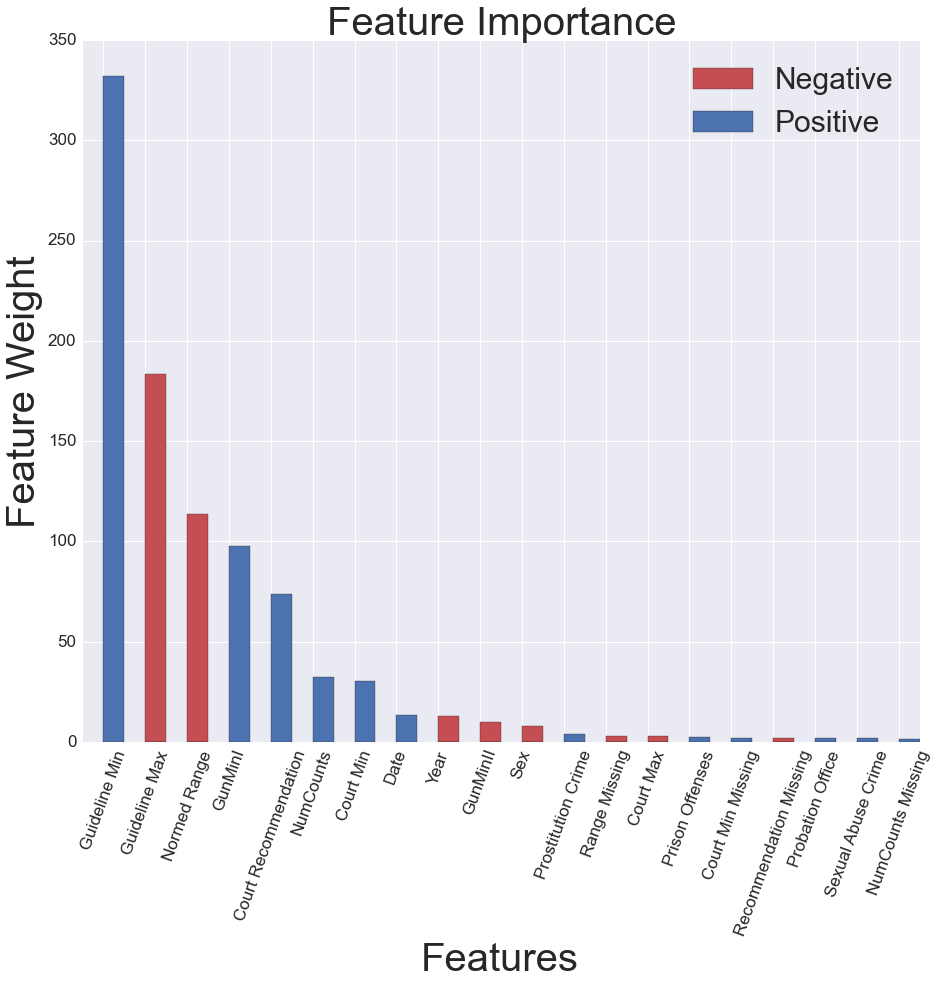

In [16]:
#Create plot of important features

features = ['Guideline Min','Guideline Max','Normed Range','GunMinI','Court Recommendation','NumCounts',
            'Court Min','Date','Year','GunMinII','Sex','Prostitution Crime','Range Missing','Court Max',
            'Prison Offenses','Court Min Missing','Recommendation Missing','Probation Office','Sexual Abuse Crime','NumCounts Missing']
ind = np.arange(20)
width = 0.5

fig = plt.figure(facecolor = 'w', figsize = (15, 15))
ax = plt.subplot(111)
plt.subplots_adjust(bottom = 0.25)

rec = ax.bar(ind + width, np.abs(neg.values()), width, color='r', label = 'Negative')
rec = ax.bar(ind + width, pos.values(), width, color='b', label = 'Positive')

ax.set_ylabel('Feature Weight', fontsize = 40)
ax.set_title('Feature Importance', fontsize = 40)
ax.set_xticks(ind + width)
ax.set_xticklabels(features, rotation = 70, fontsize = 17)
ax.set_yticklabels([0,50,100,150,200,250,300,350],fontsize = 17)
ax.set_xlabel('Features', fontsize = 40)
ax.legend(fontsize = 30)
plt.show()